In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Load the CSV file
data = pd.read_csv('data/2yrs_data.csv')

# Combine Date and Time columns into a single datetime column
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Set the new datetime column as the index
data.set_index('datetime', inplace=True)

# data.head()
# data.describe()

In [3]:
# Prediction
PREDICTION_TERM = 'Global_active_power'

# Graph
width = 14
height = 6

In [4]:
# Use the sum of <PREDICTION_TERM> per day

data = data[[PREDICTION_TERM]].resample('D').sum()

<Figure size 1400x600 with 0 Axes>

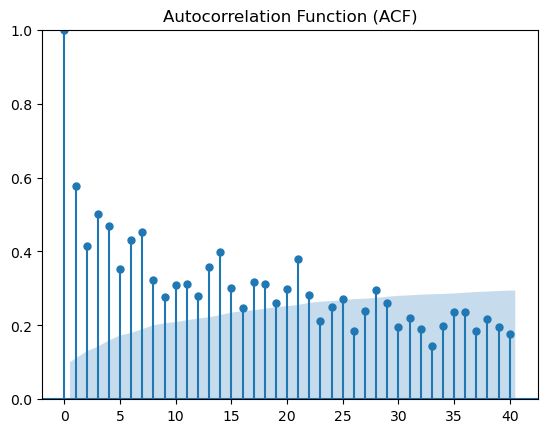

<Figure size 1400x600 with 0 Axes>

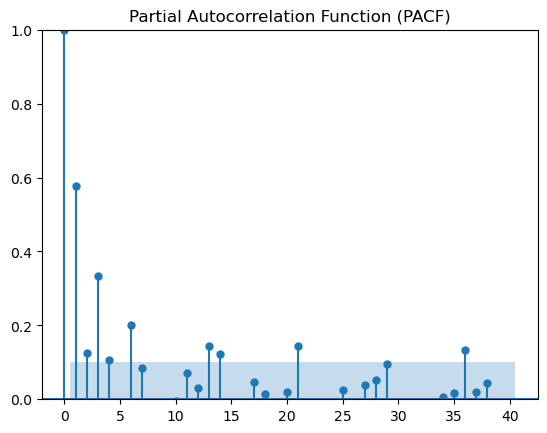

In [5]:
# Plot ACF - q
plt.figure(figsize=(width, height))
plot_acf(data[PREDICTION_TERM], lags=40)
plt.ylim(0, 1)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF - p
plt.figure(figsize=(width, height))
plot_pacf(data[PREDICTION_TERM], lags=40)
plt.ylim(0, 1)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [6]:
# Augmented Dickey-Fuller test for stationarity
result = adfuller(data[PREDICTION_TERM])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Check Stationary
d = 1
if result[1] < 0.05:
    d = 0
    print("The process is stationary.")
else:
    print("The process is not stationary.")

ADF Statistic: -2.0516196324152562
p-value: 0.2644079734870494
The process is not stationary.


In [26]:
# ARIMA
model = ARIMA(data[PREDICTION_TERM], order=(5, d, 1)) # p, d, q
arima_result = model.fit()
# print(arima_result.summary())

414.8875553348619


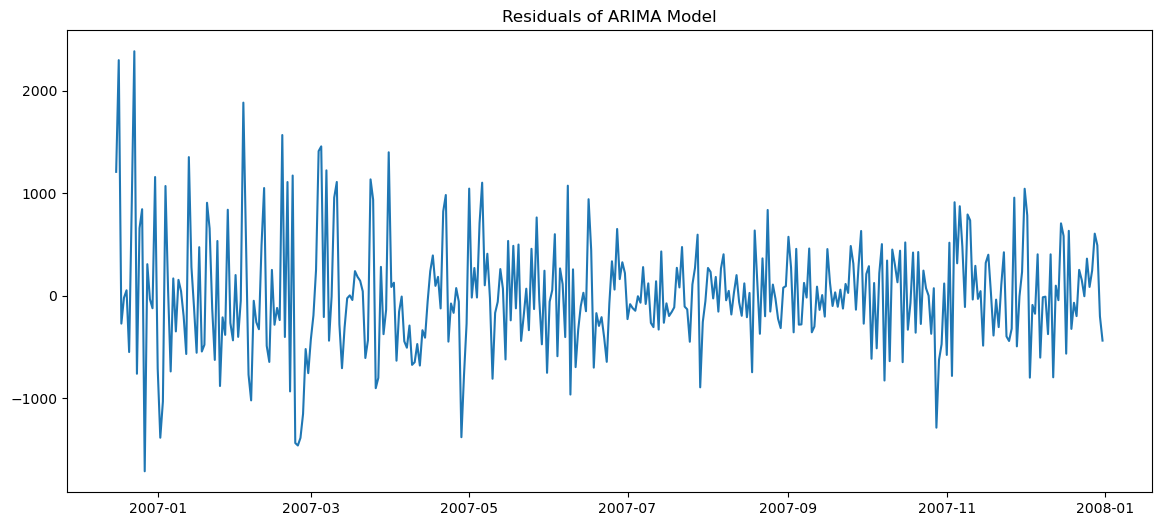

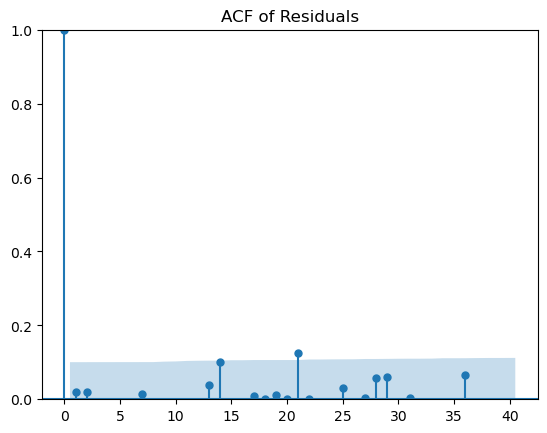

In [27]:
# Plot residuals
residuals = arima_result.resid
print(sum(abs(residuals))/len(residuals))

plt.figure(figsize=(width, height))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

# ACF of residuals to check if they resemble white noise
plot_acf(residuals, lags=40)
plt.ylim(0, 1)
plt.title('ACF of Residuals')
plt.show()

In [28]:
# Forecast the next 10 time periods
forecast = arima_result.forecast(steps=10)
print(forecast)

2008-01-01    2673.018401
2008-01-02    2675.601761
2008-01-03    2575.048912
2008-01-04    2740.465694
2008-01-05    2775.079631
2008-01-06    2600.232025
2008-01-07    2609.750602
2008-01-08    2683.030570
2008-01-09    2646.788386
2008-01-10    2633.723404
Freq: D, Name: predicted_mean, dtype: float64
